## check points
1) trading days parity
2) hyperparameter search range(original value in in comment)
3) file path and names


In [1]:
import optuna
import pandas as pd
import numpy as np
import random
import math


In [2]:
def BALANCE(weights):
    # Making sure the total sum of the weights eual to 1
    weights = [w / sum(weights) for w in weights]
    # Making sure all weights represent proportions that add up to 1
    return weights


def ratio(a, b, c):
    # function to calculate ratio i.e. "(returns-(risk_free_rate))/deviation"
    # calculating sharpe ratio
    return (a - c) / b


def number_of_years(y):  # calculates the number of years of the dataset
    p = y.index[0]  # date of first row in the dataset (datetime format)
    q = y.index[len(y) - 1]  # date of last row in the dataset  (datetime format)
    return ((q - p).days + 1) / 365

In [3]:
#df = pd.read_csv("/home/pn_kumar/Karthik/staticlookback30/n50.csv") 
df = pd.read_csv("n50.csv")
#outter read

In [4]:
len(df.columns)

25

In [5]:
aco_sharpe=pd.DataFrame(columns=['Date', 'Returns', 'Risk','Ratio'])
inputweights=[]

In [6]:
def antcolony_tuning_sharpe(ITERATIONS, Q, EVA_RATE, ANTS,start_date,end_date):
    df = pd.read_csv('n50.csv', parse_dates=['Date'], index_col='Date')
    df=df.loc[start_date:end_date]
    tdf = df.copy()  # deep copy
    df.reset_index(drop=True, inplace=True)
    #trading_days = len(df) / number_of_years(tdf)
    trading_days=60 # check here
    returnsh = df.pct_change()  # Here, returnsh would mean return considered for sharpe ratio
    returnsh.fillna(0, inplace=True)  # calculating daily returns of the stocks in the portfolio
#     returnso = returnsh.copy()  # this cell considers only NEGATIVE returns so as to calculate sortino ratio
#     for cols in returnso.columns.tolist():
#         for i in range(0, len(df)):
#             if returnso[cols][i] > 0:
#                 returnso[cols][i] = 0  
    covmatsh = returnsh.cov() * trading_days  # Annualised covariance matrix calculated wrt returnsh i.e. used to calculate sharpe ratio
    #covmatso = returnso.cov() * trading_days
    stocks = len(df.columns)              #initializing number of stocks/assets considered in the portfolio
    risk_free_rate = 0.0358     
    sharpe_pbest = -1
    # Initializing sharpe_pbest(the best fitness value   SHARPE)
    # Initializing the current fitness value
    fitness = 0
    # for each iteration
    for iteration in range(ITERATIONS):

        # PREPARAING THE PHEROMONE MATRIX WHERE THE COLS=STOCKS AND  ROWS=ANTS
        pheromon = [[0] * stocks for i in
                    range(ANTS + 1)]  # why (ants+1)?The last ant can update the pheromone values in the last row

        # Initializing the pheromone status
        for i in range(len(pheromon[0])):
            pheromon[0][i] = random.randint(1,
                                            15)  # When input stocks varies, this needs to vary accordingly.(Divide number of stocks / 2)

        # copying the values and storing it in temp_pher
        temp_pher = pheromon[0]

        # Making sure that the total amount of pheromone equals 1
        weights = np.array(BALANCE(temp_pher))

        # calculating annulaised portfolio return
        returns_temp = np.sum(returnsh.mean() * weights) * trading_days

        # calculating portfolio varience wrt calculating sharpe ratio
        varsh = np.dot(weights.T, np.dot(covmatsh, weights))

        # portfolio risk
        volatility_temp = np.sqrt(varsh)

        # Calculating fitness value(ie sharpe ratio)
        fitness = ratio(returns_temp, volatility_temp, risk_free_rate)

        # Initializing the intial fitness value as the best fitness value(sharpe_pbest)
        if sharpe_pbest == -1:
            sharpe_pbest = fitness

        # list
        path = []

        # for each ant
        for ant in range(ANTS - 1):

            # find the total pheromone
            total = sum(pheromon[ant])

            # Initializing probability
            probability = pheromon[ant][:]

            # finding probability of each stocks pheromone
            for p in range(len(probability)):
                probability[p] = (probability[p] / total)

            # Trying to select stocks in decreasing order based on their pheromone level and storing the stock order in a list(path)
            for stock in range(stocks):
                select = probability.index(max(probability))
                probability[select] = -math.inf
                path.append(select)

            # Updating the pheromone level of each stock for the next ant
            # Formula: old pheromone level * (1-eva_rate) + Q * (fitness/sharpe_pbest) where Q is fixed amount of pheromone
            for s in path:
                pheromon[ant + 1][s] = pheromon[ant][s] * (1 - EVA_RATE) + Q * (fitness / sharpe_pbest)

            # making sure that the updated pheromon adds upto 1
            temp_pher = pheromon[ant + 1]
            weights = np.array(BALANCE(temp_pher))
            returns_temp = np.sum(returnsh.mean() * weights) * trading_days  # calculating annulaised portfolio return
            varsh = np.dot(weights.T,
                           np.dot(covmatsh, weights))  # calculating portfolio varience wrt calculating sharpe ratio
            volatility_temp = np.sqrt(varsh)  # portfolio risk
            fitness = ratio(returns_temp, volatility_temp, risk_free_rate)  # calculating sharpe ratio

            # comparing the old fitness value with the updated fitness value
            # explore on scape condition paper ref
            if (fitness > sharpe_pbest):
                # if the updated fitness value is better than the previous, change sharpe_pbest to present fitness value
                sharpe_pbest = fitness

                # remembering the weights of the best portfolio
                global_warr_sharpe = weights.tolist()
        # sharpe_portfolio_return.append(returns_temp)
        # sharpe_portfolio_risk.append(volatility_temp)
        # sharpe_portfolio_shratio.append(fitness)
        # sharpe_portfolio_stockWeights.append(weights)
    return sharpe_pbest

In [7]:
# def objective(trial):
#     ITERATIONS = trial.suggest_int('ITERATIONS', 2, 5)#500
#     Q = trial.suggest_float('Q', 0.1, 1.0)
#     EVA_RATE = trial.suggest_float('EVA_RATE', 0.1, 1.00)
#     ANTS = trial.suggest_int('ANTS', 2, 5)#500
#     return antcolony_tuning_sharpe(int(ITERATIONS), Q, EVA_RATE, int(ANTS),start_date,end_date)

In [8]:
# sharpe_study = optuna.create_study(direction='maximize')
# sharpe_study.optimize(objective, n_trials=50)

# sh_hptuning = sharpe_study.trials_dataframe()
# sh_hptuning.to_csv("/home/pn_kumar/Karthik/staticlookback30/ACO_sharpe_hps.csv")
# best = sharpe_study.best_params

# ITERATIONS = int(best['ITERATIONS'])
# Q = best['Q']
# EVA_RATE = best['EVA_RATE']
# ANTS = best['ANTS']

In [6]:
def antcolony_sharpe_weights(ITERATIONS, Q, EVA_RATE, ANTS,start_date,end_date,aco_sharpe):
    df = pd.read_csv('n50.csv', parse_dates=['Date'], index_col='Date')
    df=df.loc[start_date:end_date]
    tdf = df.copy()  # deep copy
    df.reset_index(drop=True, inplace=True)
    #trading_days = len(df) / number_of_years(tdf)
    trading_days=1 # check here
    returnsh = df.pct_change()  # Here, returnsh would mean return considered for sharpe ratio
    returnsh.fillna(0, inplace=True)  # calculating daily returns of the stocks in the portfolio
#     returnso = returnsh.copy()  # this cell considers only NEGATIVE returns so as to calculate sortino ratio
#     for cols in returnso.columns.tolist():
#         for i in range(0, len(df)):
#             if returnso[cols][i] > 0:
#                 returnso[cols][i] = 0  
    covmatsh = returnsh.cov() * trading_days  # Annualised covariance matrix calculated wrt returnsh i.e. used to calculate sharpe ratio
    #covmatso = returnso.cov() * trading_days
    stocks = len(df.columns)              #initializing number of stocks/assets considered in the portfolio
    risk_free_rate = 0.0358/364

    sharpe_portfolio_return = []
    sharpe_portfolio_risk = []
    sharpe_portfolio_shratio = []
    sharpe_portfolio_stockWeights = []
    
    sharpe_pbest = -1
    # Initializing sharpe_pbest(the best fitness value   SHARPE)
    # Initializing the current fitness value
    fitness = 0
    # for each iteration
    for iteration in range(ITERATIONS):

        # PREPARAING THE PHEROMONE MATRIX WHERE THE COLS=STOCKS AND  ROWS=ANTS
        pheromon = [[0] * stocks for i in
                    range(ANTS + 1)]  # why (ants+1)?The last ant can update the pheromone values in the last row

        # Initializing the pheromone status
        for i in range(len(pheromon[0])):
            pheromon[0][i] = random.randint(1,
                                            15)  # When input stocks varies, this needs to vary accordingly.(Divide number of stocks / 2)

        # copying the values and storing it in temp_pher
        temp_pher = pheromon[0]

        # Making sure that the total amount of pheromone equals 1
        weights = np.array(BALANCE(temp_pher))

        # calculating annulaised portfolio return
        returns_temp = np.sum(returnsh.mean() * weights) * trading_days

        # calculating portfolio varience wrt calculating sharpe ratio
        varsh = np.dot(weights.T, np.dot(covmatsh, weights))

        # portfolio risk
        volatility_temp = np.sqrt(varsh)

        # Calculating fitness value(ie sharpe ratio)
        fitness = ratio(returns_temp, volatility_temp, risk_free_rate)

        # Initializing the intial fitness value as the best fitness value(sharpe_pbest)
        if sharpe_pbest == -1:
            sharpe_pbest = fitness

        # list
        path = []

        # for each ant
        for ant in range(ANTS - 1):

            # find the total pheromone
            total = sum(pheromon[ant])

            # Initializing probability
            probability = pheromon[ant][:]

            # finding probability of each stocks pheromone
            for p in range(len(probability)):
                probability[p] = (probability[p] / total)

            # Trying to select stocks in decreasing order based on their pheromone level and storing the stock order in a list(path)
            for stock in range(stocks):
                select = probability.index(max(probability))
                probability[select] = -math.inf
                path.append(select)

            # Updating the pheromone level of each stock for the next ant
            # Formula: old pheromone level * (1-eva_rate) + Q * (fitness/sharpe_pbest) where Q is fixed amount of pheromone
            for s in path:
                pheromon[ant + 1][s] = pheromon[ant][s] * (1 - EVA_RATE) + Q * (fitness / sharpe_pbest)

            # making sure that the updated pheromon adds upto 1
            temp_pher = pheromon[ant + 1]
            weights = np.array(BALANCE(temp_pher))
            returns_temp = np.sum(returnsh.mean() * weights) * trading_days  # calculating annulaised portfolio return
            varsh = np.dot(weights.T,
                           np.dot(covmatsh, weights))  # calculating portfolio varience wrt calculating sharpe ratio
            volatility_temp = np.sqrt(varsh)  # portfolio risk
            fitness = ratio(returns_temp, volatility_temp, risk_free_rate)  # calculating sharpe ratio

            # comparing the old fitness value with the updated fitness value
            # explore on scape condition paper ref
            if (fitness > sharpe_pbest):
                # if the updated fitness value is better than the previous, change sharpe_pbest to present fitness value
                sharpe_pbest = fitness

                # remembering the weights of the best portfolio

                global_warr_sharpe = weights.tolist()

            sharpe_portfolio_return.append(returns_temp)
            sharpe_portfolio_risk.append(volatility_temp)
            sharpe_portfolio_shratio.append(fitness)
            sharpe_portfolio_stockWeights.append(weights)
        
    portfolio = {'Returns' : sharpe_portfolio_return, 'Standard Deviation' : sharpe_portfolio_risk, 'Sharpe Ratio' : sharpe_portfolio_shratio}
    for counter,symbol in enumerate(df.columns):
        portfolio[symbol + " Weight"] = [Weight[counter] for Weight in sharpe_portfolio_stockWeights]
    pc = pd.DataFrame(portfolio)
    pc.loc[:, :] *= 100
    pc['Sharpe Ratio']=pc['Sharpe Ratio']/100 
    max_sharpe=pc['Sharpe Ratio'].max()     
    max_sharpe_portfolio=pc.loc[pc['Sharpe Ratio'] == max_sharpe]
    max_weights=max_sharpe_portfolio.values
    max_weights=max_weights[0][3:]
    return max_weights


In [10]:
#tuned = antcolony_sharpe_weights(ITERATIONS, Q, EVA_RATE, ANTS,start_date,end_date,aco_sharpe)

In [7]:
def ACO_Sharpe_lookback(start_date,end_date,deciding_date,aco_sharpe,inputweights):
    aco_sharpe_list=[]
    df = pd.read_csv('n50.csv', parse_dates=['Date'], index_col='Date')
    df=df.loc[start_date:end_date]
    tdf = df.copy()  # deep copy
    df.reset_index(drop=True, inplace=True)
    #trading_days = len(df) / number_of_years(tdf)
    trading_days=1
    returnsh = df.pct_change()  # Here, returnsh would mean return considered for sharpe ratio
    returnsh.fillna(0, inplace=True)  # calculating daily returns of the stocks in the portfolio
#     returnso = returnsh.copy()  # this cell considers only NEGATIVE returns so as to calculate sortino ratio
#     for cols in returnso.columns.tolist():
#         for i in range(0, len(df)):
#             if returnso[cols][i] > 0:
#                 returnso[cols][i] = 0  
    covmatsh = returnsh.cov() * trading_days  # daily covariance matrix calculated wrt returnsh i.e. used to calculate sharpe ratio
    #covmatso = returnso.cov() * trading_days  # daily covariance matrix calculated wrt returnso i.e. used to calculate sortino ratio
    num_assets = len(df.columns)  # initializing number of stocks/assets considered in the portfolio
    risk_free_rate = 0.0358/364  #initializing risk free rate that will be used in calculating both the ratios (absolute value)
# referred from url: https://www.rbi.org.in/Scripts/BS_NSDPDisplay.aspx?param=4&Id=24292
# In the above url, the 364 (1 year) day treasury bill is 3.58% , when taken absolute value => 0.0358
# (improved)
    global_war_sharpe=[]
    sharpe_portfolio_return=[]
    sharpe_portfolio_risk=[]
    sharpe_portfolio_shratio=[]
    sharpe_portfolio_stockWeights=[]
    fitness=0
    weights=np.array(BALANCE(np.array(inputweights)))
    returns_temp = np.sum(returnsh.mean()*weights)*trading_days 
    varsh=np.dot(weights.T,np.dot(covmatsh,weights))   
    volatility_temp = np.sqrt(varsh)      
    fitness = ratio(returns_temp,volatility_temp,risk_free_rate)
    sharpe_portfolio_return.append(returns_temp)
    sharpe_portfolio_risk.append(volatility_temp)
    sharpe_portfolio_shratio.append(fitness)
    sharpe_portfolio_stockWeights.append(weights)
    sharpe_portfolio = {'Returns' : sharpe_portfolio_return, 'Standard Deviation' : sharpe_portfolio_risk,  'Sharpe Ratio' : sharpe_portfolio_shratio}  
    for counter,symbol in enumerate(df.columns):
      sharpe_portfolio[symbol + " Weight"] = [Weight[counter] for Weight in sharpe_portfolio_stockWeights]
    sharpe_pc = pd.DataFrame(sharpe_portfolio)
    sharpe_optimal=sharpe_pc.iloc[sharpe_pc['Sharpe Ratio'].idxmax()]
    sharpe_optimal=sharpe_optimal.to_frame()
    sharpe_optimal=sharpe_optimal.transpose()
    sharpe_optimal.loc[:, :] *= 100
    sharpe_optimal.loc[:, 'Sharpe Ratio'] /= 100
    to_append=[deciding_date,sharpe_optimal['Returns'].values[0],sharpe_optimal['Standard Deviation'].values[0],sharpe_optimal['Sharpe Ratio'].values[0]]
    aco_sharpe_series = pd.Series(to_append, index = aco_sharpe.columns)
    aco_sharpe = aco_sharpe.append(aco_sharpe_series, ignore_index=True)
    sharpe_optimal.to_csv(str(deciding_date)+"sharpe_ACO_dynamic.csv")
    print(aco_sharpe)
    return aco_sharpe

In [8]:
start_date="2016-01-01"

In [9]:
start_date_index=df.index[df['Date'] == start_date] 

In [10]:
end_date="2020-09-30"

In [11]:
end_date_index=df.index[df['Date']== end_date]

In [12]:
start_date_lookback="2020-10-01"

In [13]:
start_date_lookback_index=df.index[df['Date'] == start_date_lookback] 

In [14]:
end_date_lookback="2020-12-31"

In [15]:
end_date_lookback_index=df.index[df['Date']== end_date_lookback]

In [16]:
while df.iloc[end_date_index].Date.values[0]:
    ITERATIONS = 335#int(best['ITERATIONS'])
    Q = 0.43077#best['Q']
    EVA_RATE = 0.7294#best['EVA_RATE']
    ANTS = 20#best['ANTS']
    inputweights=antcolony_sharpe_weights(ITERATIONS,Q,EVA_RATE,ANTS,df.iloc[start_date_index].Date.values[0],df.iloc[end_date_index].Date.values[0],aco_sharpe)
    aco_sharpe=ACO_Sharpe_lookback(df.iloc[start_date_lookback_index].Date.values[0],df.iloc[end_date_lookback_index].Date.values[0],df.iloc[end_date_lookback_index+1].Date.values[0],aco_sharpe,inputweights)
    start_date_lookback_index+=1
    end_date_lookback_index+=1
    start_date_index+=1
    end_date_index+=1

         Date   Returns      Risk     Ratio
0  2021-01-01  0.338583  0.885928  0.371078
         Date   Returns      Risk     Ratio
0  2021-01-01  0.338583  0.885928  0.371078
1  2021-01-04  0.350822  0.871322  0.391345
         Date   Returns      Risk     Ratio
0  2021-01-01  0.338583  0.885928  0.371078
1  2021-01-04  0.350822  0.871322  0.391345
2  2021-01-05  0.341167  0.866143  0.382536
         Date   Returns      Risk     Ratio
0  2021-01-01  0.338583  0.885928  0.371078
1  2021-01-04  0.350822  0.871322  0.391345
2  2021-01-05  0.341167  0.866143  0.382536
3  2021-01-06  0.367720  0.895684  0.399566
         Date   Returns      Risk     Ratio
0  2021-01-01  0.338583  0.885928  0.371078
1  2021-01-04  0.350822  0.871322  0.391345
2  2021-01-05  0.341167  0.866143  0.382536
3  2021-01-06  0.367720  0.895684  0.399566
4  2021-01-07  0.312609  0.856805  0.353376
         Date   Returns      Risk     Ratio
0  2021-01-01  0.338583  0.885928  0.371078
1  2021-01-04  0.350822  0.87132

IndexError: positional indexers are out-of-bounds

In [17]:
aco_sharpe.to_csv('aco_sharpe_dynamic.csv')

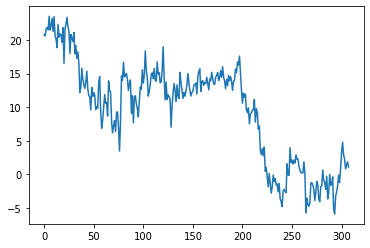

In [24]:
import matplotlib.pyplot as plt
plt.plot(aco_sharpe.Returns)